We will use weather data only from the San Diego Lindbergh Field weather station, which is assigned to the highest number of incidents and is at a central location 

In [23]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time

# Package to calculate distance between two coordinates
import geopy.distance

# Library for regular expression operations
import re

# Import supplementary visualization code visuals.py
import visuals as vs

# Suppress matplotlib user warnings
# Necessary for newer version of matplotlib
import warnings
warnings.filterwarnings("ignore")

# Import libraries for data visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import seaborn as sns
sns.set()

# Pretty display for notebooks
%matplotlib inline

In [31]:
# Load the engineered weather station data for the San Diego Lindbergh Field Station
sdlf=pd.read_csv('san_diego_lindbergh_field_engineered.csv',header=0,parse_dates=True)
sdlf.head()

,date,high_low_diff,high_temp_diff,high_temp_alert,rain_alert,observed_precipitation,observed_low,observed_high
0,2016-09-01,8,NaN,0,0,0.0,64,72
1,2016-09-02,10,1.0,0,0,0.0,63,73
2,2016-09-03,6,-3.0,0,0,0.0,64,70
3,2016-09-04,9,4.0,0,0,0.0,65,74
4,2016-09-05,7,-2.0,0,0,0.0,65,72


In [4]:
# Load the data for all incidents
parse_dates = ['Response_Date']
incidents_sd=pd.read_csv('incidents_sd.csv',header=0,parse_dates=parse_dates)
incidents_sd.columns

Index(['ID', 'Latitude_Decimal', 'Longitude_Decimal', 'Postal_Code',
       'Response_Date', 'Problem', 'assigned_station'],
      dtype='object')

In [7]:
# Find the value counts of all problem types in the date set  
incidents_sd['Problem'].value_counts()

Sick Person (Specific Dx)(L1)     39706
Unc/Fainting (Non Trauma)(L1)     35695
Breathing Problems (L1)           35165
Falls / Back Inj (Trauma) (L1)    31343
Traffic Accident (L1)             31234
                                  ...  
Electrocution (L2c)                   1
Abdominal Pain/Problems (L2c)         1
Animal Bites/ Attacks (L1c)           1
Abdominal Pain/Problems (L1b)         1
Convulsions / Seizures (L1b)          1
Name: Problem, Length: 218, dtype: int64

There are 218 problem types in the data set. We will show the ten most common problem types:

In [13]:
# Show the ten most common incident types
pd.DataFrame(incidents_sd['Problem'].value_counts().iloc[0:10].index, columns=['Ten_Most_Common_Problems'])

,Ten_Most_Common_Problems
0,Sick Person (Specific Dx)(L1)
1,Unc/Fainting (Non Trauma)(L1)
2,Breathing Problems (L1)
3,Falls / Back Inj (Trauma) (L1)
4,Traffic Accident (L1)
5,Chest Pain (L1)
6,Sick Person (Specific Dx)(L4)
7,Convulsions / Seizures (L1)
8,Assault/Rape (L1)
9,Hemorrhage / Lacerations (L1)


Three problem types are chosen to explore as they are among the most common problems, are specific enough and might be correlated with temperature: breathing problems, traffic accidents and chest pain.

In [14]:
# Create a column which contains only the date of the incident, not time of day 
incidents_sd['Response_Day'] = incidents_sd['Response_Date'].dt.date

In [16]:
# Create a dataframe which includes incidents with breathing problems only
incidents_breathing=incidents_sd[incidents_sd['Problem'].str.contains('Breathing',regex=True)][['ID','Response_Day','Problem']]
incidents_breathing['Problem'].value_counts()

Breathing Problems (L1)     35165
Breathing Problems (L1a)     1077
Breathing Problems (L3)        22
Breathing Problems (L4)         3
Breathing Problems (L3a)        1
Name: Problem, dtype: int64

In [19]:
# Group the incidents related to breathing by the number of incidents per day
incidents_breathing_grouped=incidents_breathing.groupby(['Response_Day'],as_index=False)['ID'].count()
incidents_breathing_grouped['breathing_problems']=incidents_breathing_grouped['ID']

In [20]:
# Create a dataframe which includes incidents related to chest pain only
incidents_chest=incidents_sd[incidents_sd['Problem'].str.contains('Chest',regex=True)][['ID','Response_Day','Problem']]
incidents_chest['Problem'].value_counts()

Chest Pain (L1)     29576
Chest Pain (L3)       816
Chest Pain (L1a)      531
Chest Pain (L2a)      350
Chest Pain (L3a)       24
Name: Problem, dtype: int64

In [21]:
# Group the incidents related to chest pain by the number of incidents per day
incidents_chest_grouped=incidents_chest.groupby(['Response_Day'],as_index=False)['ID'].count()
incidents_chest_grouped['chest_pain']=incidents_chest_grouped['ID']

In [22]:
# Create a dataframe which includes incidents related to traffic accidents only
incidents_traffic=incidents_sd[incidents_sd['Problem'].str.contains('Traffic',regex=True)][['ID','Response_Day','Problem']]
incidents_traffic['Problem'].value_counts()

Traffic Accident (L1)           31234
Traffic Accident FWY              180
Traffic Accident FWY (CV/NC)        5
Traffic Accident (L3)               3
Name: Problem, dtype: int64

In [29]:
# Group the incidents related to traffic accidents by the number of incidents per day
incidents_traffic_grouped=incidents_traffic.groupby(['Response_Day'],as_index=False)['ID'].count()
incidents_traffic_grouped['traffic_accidents']=incidents_traffic_grouped['ID']

In [25]:
# Draw a heatmap of correlations between all numeric features
def correlation_matrix(dataset):
    numeric_columns=dataset.select_dtypes(include=['int','float']).columns.values.tolist()
    fig, ax = plt.subplots(figsize=(7,7))     
    sns.heatmap(dataset[numeric_columns].corr(),cmap='viridis_r', annot=True, ax=ax)
    fig.tight_layout()
    fig.show() 

In [32]:
input_output=pd.concat([sdlf['observed_high'],incidents_traffic_grouped['traffic_accidents'],incidents_chest_grouped['chest_pain'],incidents_breathing_grouped['breathing_problems']],axis=1)
input_output.head()

,observed_high,traffic_accidents,chest_pain,breathing_problems
0,72,38,35,28
1,73,35,28,23
2,70,28,33,32
3,74,19,22,30
4,72,13,18,34


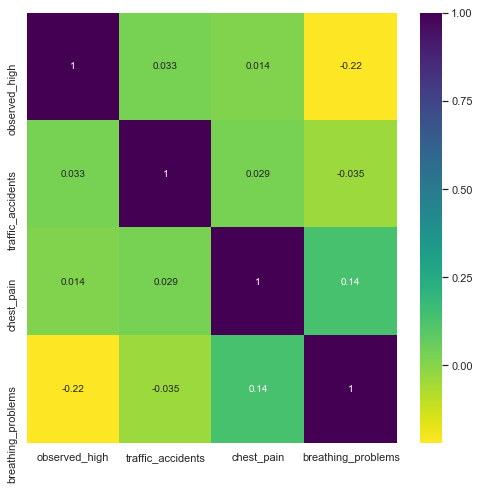

In [33]:
# Draw the correlation matrix with seven days of number of incidents and all weather related features
correlation_matrix(input_output)

Only the number of incidents related to breathing problems seem to show some correlation with the observed high temperature during the day: As the temperature increases, the number of breathing problems decrease. This might be because the humidity tends to decrease as the temperature increases in San Diego. This kind of analysis might be useful to determine the material needs in ambulances depending on the expected increase in the particular types of problems as the temperatures increase. Further exploration can shed light on the relationship of other types of incidents with the observed high temperature during the day.